# Porto Seguro’s Safe Driver Prediction

## Autor

Erick Melo Vidal de Olvieira - 190027355

## Objetivo




Este artigo tem como objetivo participar da competição [Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/overview) e demonstrar a evolução do score na tabela de classificação.

## Importando o DataSet

In [21]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

train  = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/test.csv')
train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,1488013,0,3,1,10,0,0,0,0,0,...,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,...,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,...,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,...,4,1,4,2,0,1,1,1,0,0


## Tratando os dados

Primeiramente, devemos separar as variáveis que formaram o modelo de submissão da competição, sendo elas a 'id' e a 'target' e em seguida retirá-las do dataset de treino e validação.

In [22]:
id_test = test['id'].values
target = train['target'].values

train = train.drop(['target', 'id'], axis = 1)
test = test.drop(['id'], axis = 1)

As colunas que começam com "ps_calc_" são criadas pela função "create_calc_features" e são geradas a partir de combinações de outras colunas. Elas não são diretamente relevantes para o dataset, e incluí-las ou não incluí-las não afetará o resultado final. Então, como eu já havia tentado criar um modelo com o dataset completo, estarei removendo estas colunas desta vez para verificar se há uma melhora.

In [23]:
dropColumns = train.columns[train.columns.str.startswith('ps_calc_')]
dropColumns

Index(['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],
      dtype='object')

In [24]:
train = train.drop(dropColumns, axis=1)
test = test.drop(dropColumns, axis=1)

Na descrição dos dados da competição, é informado que os valores ausentes constam como -1 no dataset, porém, para tratar melhor esse dado posteriormente seria melhor que os valores ausentes estivessem como NaN. Então é isso que iremos fazer, substituir todos os valores -1 por NaN.

In [25]:
train = train.replace(-1, np.nan)
test = test.replace(-1, np.nan)

Em seguida vamos tratar as colunas categóricas, que neste dataset está representada por "cat" no final do nome da coluna. Então vou separá-las em uma variável e a partir dela fazer um dummie para o dataset de traino e de validação.

In [26]:
catColumns = [a for a in train.columns if a.endswith('cat')]
catColumns

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [27]:
for column in catColumns:
    temp = pd.get_dummies(pd.Series(train[column]))
    train = pd.concat([train, temp], axis=1)
    train = train.drop([column], axis=1)
    temp = pd.get_dummies(pd.Series(test[column]))
    test = pd.concat([test, temp], axis = 1)
    test = test.drop([column], axis=1)

## Stacking

Ensemble e Stacking são dois métodos de combinar diferentes modelos de aprendizado de máquina em uma única previsão. A diferença entre eles é que, no Ensemble, os modelos são treinados separadamente e suas previsões são agregadas (por exemplo, por média ou voto majoritário), enquanto no Stacking, as previsões dos modelos são utilizadas como entrada para outro modelo, que é treinado para fazer a previsão final. Portanto, o Stacking é uma extensão do Ensemble, em que o modelo final é treinado para combinar as previsões dos modelos individuais.

Então, pesquisando um pouco encontrei esta função de [Stacking](https://www.kaggle.com/code/yekenot/simple-stacker-lb-0-284) que foi disponibilizada para o uso. Porém, alterei ela para tentar equilibrar os dados antes do treinamento dos modelos.

In [28]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models
        
    def fit_predict(self, X, y, T):
        
        # ajustando proporção das classes
        pos = pd.Series(y == 1)
        y = pd.Series(y)
        X = pd.concat([X, X.loc[pos]], axis = 0)
        y = pd.concat([y, y.loc[pos]], axis = 0)
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        X = X.iloc[idx]
        y = y.iloc[idx]
        
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        
        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle = True, random_state=17).split(X, y))
        
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        
        
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))
            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                

                print("fit %s fold %d " %(str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                y_pred = clf.predict_proba(X_holdout)[:, 1]
                
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:, 1]
            S_test[:, i] = S_test_i.mean(axis=1)
        result = cross_val_score(self.stacker, S_train, y, cv=3)
        print("Stacker score : %.5f "%(result.mean()))
        self.stacker.fit(S_train, y)
        
        res = self.stacker.predict_proba(S_test)[:, 1]
        return res

Para a criação dos modelos eu utilizarei o LGBMClassifier, que é um algoritmo de gradient boosting para a construção de modelos de classificação. Ele funciona ao criar uma série de árvores de decisão e combiná-las para produzir um modelo mais forte.

A cada iteração, o algoritmo de gradient boosting tenta corrigir os erros cometidos pelo modelo anterior adicionando uma nova árvore de decisão que foque na correção desses erros. Isso é feito através da minimização de uma perda, geralmente a logloss para classificação, através da otimização dos parâmetros da nova árvore.

Os parâmetros que serão passados para a criação deste modelo são os seguintes:
* learning_rate : é a taxa de aprendizado, que controla o quão rápido o modelo aprende.
* n_estimators : é o número de árvores no modelo.
* max_bin : é o número máximo de bins para dividir recursos durante a construção de árvores.
* subsample : é a porcentagem de amostras aleatórias a serem usadas para cada árvore.
* subsample_freq : é a frequência com a qual o subsample é aplicado.
* colsample_bytree : é a porcentagem de recursos aleatórios a serem usados para cada árvore.
* min_child_samples : é o número mínimo de amostras necessárias em uma * folha de uma árvore.
* seed : é a semente utilizada para o processo de aleatoriedade do modelo.

In [29]:
params = {
    'learning_rate' : 0.02,
    'n_estimators' : 650,
    'max_bin' : 10,
    'subsample' : 0.8,
    'subsample_freq' : 10,
    'colsample_bytree' : 0.8,
    'min_child_samples' : 500,
    'seed' : 99
}

params2 = {
    'learning_rate' : 0.03,
    'n_estimators' : 800,
    'max_bin' : 12,
    'subsample' : 0.5,
    'subsample_freq' : 10,
    'colsample_bytree' : 0.8,
    'min_child_samples' : 500,
    'seed' : 55
}

model1 = LGBMClassifier(**params)
model2 = LGBMClassifier(**params2)
model3 = LGBMClassifier()

Em seguida utilizarem como modelo final o Logistic Regression, por ser mais simples de usar, além de ser computacionalmente eficiente. Além disso, o Logistic Regression é capaz de lidar com problemas de classificação binária ou multi-classe, o que é importante para o Stacking. Portanto, usar este modelo como base para o Stacker pode fornecer resultados confiáveis e precisos.

In [30]:
log_model = LogisticRegression()

In [31]:
stack = Ensemble(n_splits = 3, stacker = log_model, base_models = (model1, model2, model3))

## Treinando o modelo

Para treinar o modelo, então, basta chamar a função `fit_predict` da classe Ensemble criada anteriormente. 

In [32]:
y_pred = stack.fit_predict(train, target, test)

fit LGBMClassifier fold 1 
fit LGBMClassifier fold 2 
fit LGBMClassifier fold 3 
fit LGBMClassifier fold 1 
fit LGBMClassifier fold 2 
fit LGBMClassifier fold 3 
fit LGBMClassifier fold 1 
fit LGBMClassifier fold 2 
fit LGBMClassifier fold 3 
Stacker score : 0.92940 


Podemos notar que o modelo final conseguiu um score de quase 93%

In [33]:
y_pred

array([0.05519708, 0.04535141, 0.0470127 , ..., 0.07061781, 0.04289163,
       0.05563767])

In [34]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_pred
submission.to_csv('submission.csv', index=False)

## Conclusão

Inicialmente eu havia tentado apenas criar uma Random Forest e submeter na competição, e meu resultado foi horrível. Em seguida, tentei implementar um Stacking sem nenhum tratamento de dados e mesmo assim continuou ruim. Então, apenas com essa versão atual que consegui um score maior na competição.

Esses foram os meus resultados:

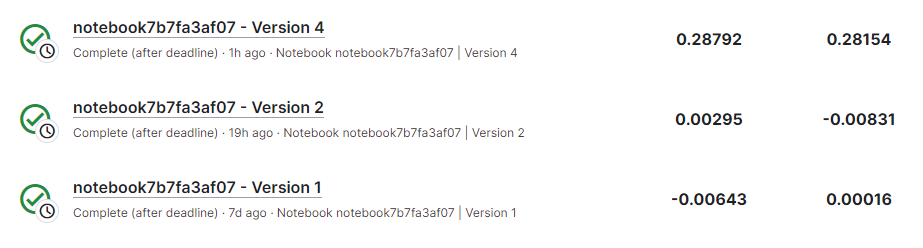